# Setup

In [1]:
if __name__ == '__main__' and __package__ is None:
    from os import sys, path
    # __file__ should be defined in this case
    PROJECT_DIR = path.dirname(path.dirname(path.abspath("__file__")))
    SOURCE_DIR = path.join(PROJECT_DIR, "src/model")
    sys.path.append(SOURCE_DIR)

In [2]:
from typing import List, Dict, Any, Union, Optional, Literal
import pandas as pd
import os
import json
import copy
import pathlib
import re
import dill
import time
import datetime
import numpy as np
from collections import Counter
from functools import partial
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import string
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data
# nltk.download('stopwords')
# nltk.download('wordnet')

In [3]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.precision", 4)
pd.set_option("display.max_rows", 40)
pd.set_option('display.max_columns', 50)

%matplotlib inline

In [4]:
# auto-reload
%load_ext autoreload
%autoreload 2

# Work

## 1. Helper funcs

In [6]:
class FeatureStore:
    data_dir = path.join(PROJECT_DIR, "data")

    @classmethod
    def _get_all_items(cls, root: pathlib.Path):
        for item in root.iterdir():
            yield item
            if item.is_dir():
                yield from cls._get_all_items(item)
    @classmethod
    def list_inputs(cls):
        input_dir = path.join(cls.data_dir, "inputs")
        root = pathlib.Path(input_dir)
        return list(cls._get_all_items(root=root))

    @classmethod
    def list_output(cls):
        output_dir = path.join(cls.data_dir, "outputs")
        root = pathlib.Path(output_dir)
        return list(cls._get_all_items(root=root))

    @classmethod
    def load(cls, stage:Literal["inputs", "outputs"], filename:str) -> pd.DataFrame:
        if stage not in ["inputs", "outputs"]:
            raise ValueError(f"Available stages are <inputs> and <outputs>")
        file = pathlib.Path(os.path.join(cls.data_dir, stage, filename))
        if file.is_file():
            return pd.read_parquet(file)
        else:
            raise ValueError(f"File {filename} doesnt exist!")

    @classmethod
    def save(cls, df:pd.DataFrame, stage:Literal["inputs", "outputs"], filename:str) -> None:
        if stage not in ["inputs", "outputs"]:
            raise ValueError(f"Available stages are <inputs> and <outputs>")
        file = pathlib.Path(os.path.join(cls.data_dir, stage, f"{filename}.parquet"))
        df.to_parquet(path=file, compression="snappy")

class ModelRegistry:
    """
    Dill is better at serialization other objects such as functions
    and classes, etc.
    """
    dir = path.join(PROJECT_DIR, "data", "models")

    @classmethod
    def list_models(cls):
        root = pathlib.Path(cls.dir)
        return list(cls._get_all_items(root=root))

    @classmethod
    def _get_all_items(cls, root: pathlib.Path):
        for item in root.iterdir():
            yield item
            if item.is_dir():
                yield from cls._get_all_items(item)

    @classmethod
    def load(cls, filename:str) -> Pipeline:
        file = pathlib.Path(os.path.join(cls.dir, filename))
        if file.is_file():
            with open(file, 'rb') as f:
                loaded_pipeline = dill.load(f)
            return loaded_pipeline
        else:
            raise ValueError(f"File {filename} doesnt exist!")

    @classmethod
    def save(cls, pipeline:Pipeline, name:str) -> None:
        now = datetime.datetime.utcnow().strftime('%Y%m%d')
        filename = f"{name}_{now}.joblib"
        file_path = path.join(cls.dir, filename)
        with open(file_path, 'wb') as f:
            dill.dump(pipeline, f)

In [7]:
def standartize_columns(df):
    new_columns = ["_".join(x.lower().split(" ")) for x in list(df.columns)]
    df.columns = new_columns
    return df

def text_cleaning(df, columns:List[str]):
    for column in columns:
        # lower
        df[column]=df[column].apply(lambda x: x.lower())
        
        # Remove digits and words containing digits
        # df[column]=df[column].apply(lambda x: re.sub('\w*\d\w*','', x))
        
        # Remove Punctuations
        df[column]=df[column].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

        # Removing extra spaces
        df[column]=df[column].apply(lambda x: re.sub(' +', ' ', x))
    return df

def standartize_text(df, columns:List[str]):
    def func(text):
        stop_words = set(stopwords.words('english'))
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
        return text
        
    for column in columns:
        df[column] = df[column].apply(func)
    return df

def word_count(text:str) -> int:
    text_list = text.split()
    return len(text_list)

def get_top_values(text:str, n:int=10):
    return " ".join([val for val, count in Counter(text.split(" ")).most_common(n)])


## 2. Data Cleaning

In [8]:
_df=FeatureStore.load(stage="inputs", filename="cc_data.parquet")
_df=standartize_columns(df=_df)
df = copy.deepcopy(_df)
df=text_cleaning(df=df, columns=["title", "abstract"])
df=standartize_text(df=df, columns=["title", "abstract"])

# Concatenate values into 'label' column
label_columns = ['computer_science', 'physics', 'mathematics', 'statistics', 'quantitative_biology', 'quantitative_finance']
df['label'] = df.apply(lambda row: '|'.join([col for col in label_columns if row[col] == 1]), axis=1)
df=df.drop(label_columns, axis=1)

# concatinating title and abstract. We'll treat it as one
# as some abstracts are uninformative, however title is
df["text"] = df["title"] + " " + df["abstract"]
df=df.drop(["title", "abstract"], axis=1)

df.head()

,label,text
0,mathematics|statistics,characterization multivariate bernoulli distri...
1,mathematics,distinction representation via bruhattits buil...
2,physics,origin shallow replica band fese monolayer sup...
3,computer_science|statistics,explaining recurrent neural network prediction...
4,statistics,estimator correlation coefficient bivariate ex...


In [9]:
# DROPING DUPLICATE ROWS
df=df.drop(df[df.duplicated("text", keep="first")].index)

In [10]:
# calculating some text statistics
df['length'] = df['text'].str.len()
df['word_count'] = df['text'].apply(word_count)
df['mean_word_length'] = df['text'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
df["text_top_5"]=df["text"].apply(partial(get_top_values, n=5))
df["text_top_10"]=df["text"].apply(partial(get_top_values, n=10))

In [11]:
df.head(5)

,label,text,length,word_count,mean_word_length,text_top_5,text_top_10
0,mathematics|statistics,characterization multivariate bernoulli distri...,620,73,7.5068,given margin fréchet class distribution,given margin fréchet class distribution densit...
1,mathematics,distinction representation via bruhattits buil...,391,49,7.0000,distinction representation article françois co...,distinction representation article françois co...
2,physics,origin shallow replica band fese monolayer sup...,1138,132,7.6288,band arpes substrate fesesto lda,band arpes substrate fesesto lda experiment co...
3,computer_science|statistics,explaining recurrent neural network prediction...,651,74,7.8108,network recurrent neural relevance lrp,network recurrent neural relevance lrp predict...
4,statistics,estimator correlation coefficient bivariate ex...,526,58,8.0862,estimator correlation coefficient exponential ...,estimator correlation coefficient exponential ...


## 3. EDA

In [12]:
from model.utils.viz.categorical.simple import pieplot

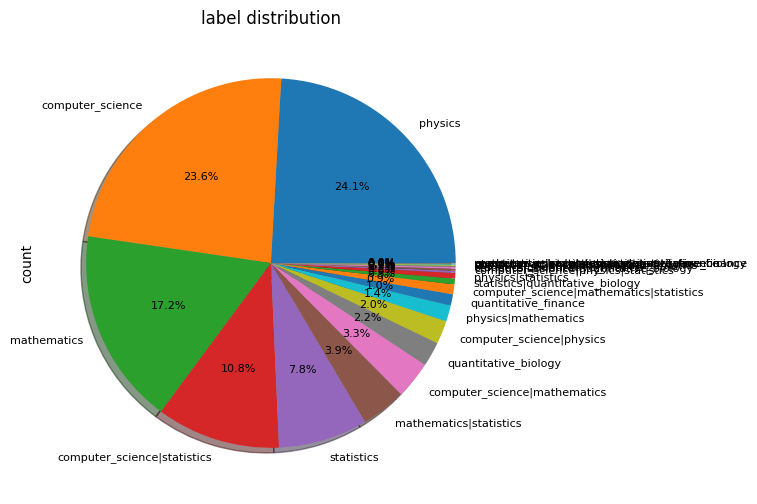

In [13]:
# very low count for big labels - wel'll have to reduce the label count
# you can also see class imbalance that's why we'll be using stratified kfolds in training
pieplot(df=df, target="label")

In [14]:
# using caridanality treshold of 2% we can reduce really small classes and naming them as others
# however, there still some minor classes below 3% which we can also consider adding to the "other" group
cardinality_treshold=len(df)*0.02
labels_to_change=[val for val, count in Counter(df["label"]).items() if count>cardinality_treshold]
df["label"]=df["label"].apply(lambda x:x if x in labels_to_change else "other")

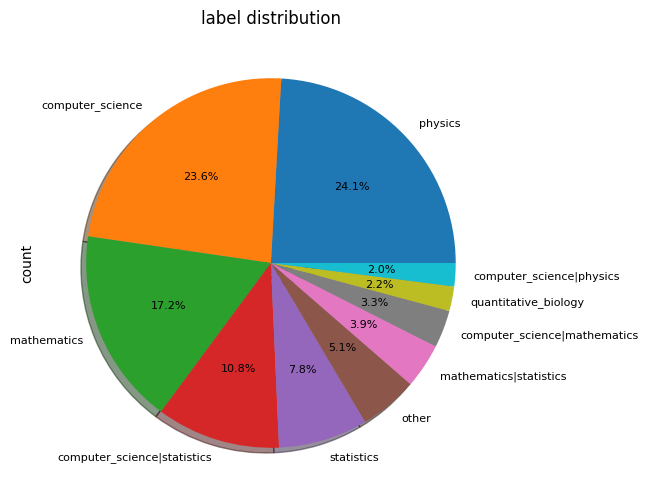

In [15]:
pieplot(df=df, target="label")

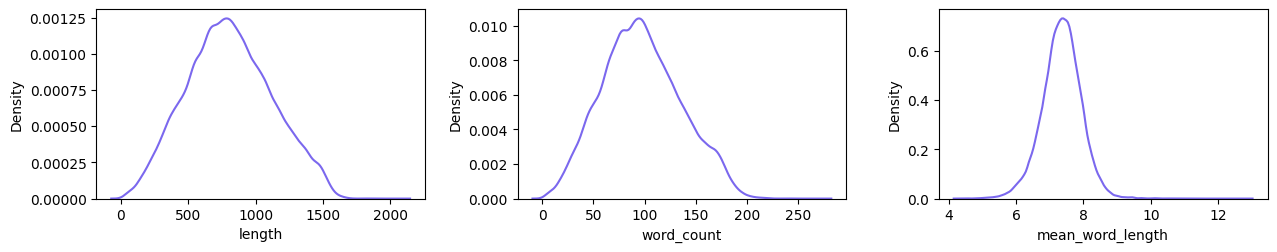

In [16]:
from model.utils.viz.continuous.group import distribution
# some general distributions
distribution(df=df)

In [17]:
from model.utils.viz.continuous.simple import distribution

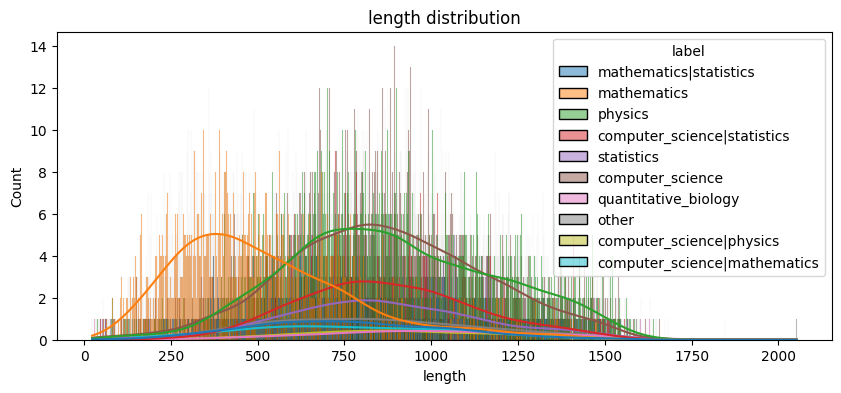

In [18]:
# it seems that mathematics label is usually shorter in text lengh
# physics and computer_science on average is 700-800 words
distribution(df=df, column="length", target="label")

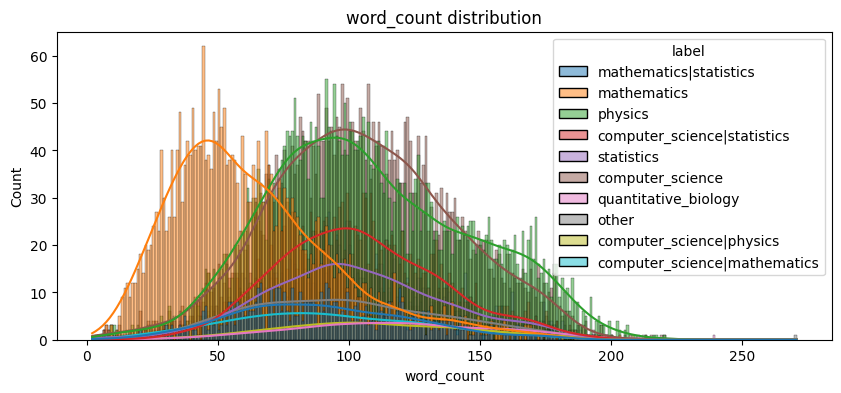

In [19]:
# same insights from mathematics, physics and computer_science
# however it seems that computer_science|statistics and quantative_biology are using 
# are on average using 100 words however they seem to be shorter in lenght. Maybe using simple words in the abastract
# in comparison to math, physics and computer_science?
distribution(df=df, column="word_count", target="label")

In [20]:
df.loc[df["word_count"]<5][["text","label"]]

,text,label
831,thicket density thicket,mathematics
4333,theoretical result result yes,quantitative_biology
4799,betweenclass learning image classification,computer_science|statistics
6129,evansselberg potential planar domain,mathematics
6921,complexity enumeration,computer_science
10612,predicting gender indonesian name,computer_science
15299,measured multiseries integration,computer_science


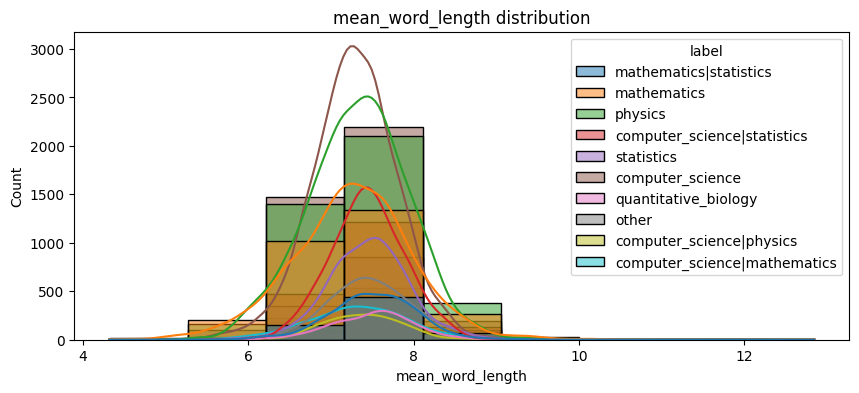

In [21]:
# seems to be correct, math, physhics and cs are one average using longer words 
# maybe complex words | technical words
distribution(df=df, column="mean_word_length", target="label")

In [22]:
from wordcloud import WordCloud

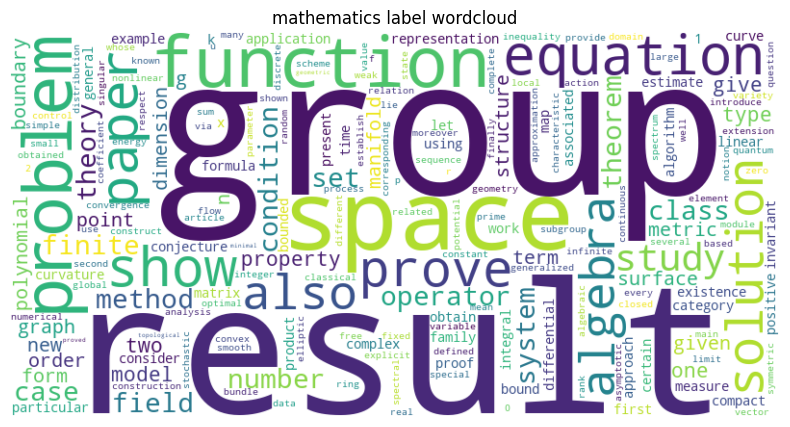

In [23]:
data=df.loc[df["label"]=="mathematics"]["text"]
combined_text = ' '.join(data)
words = combined_text.split()
count=Counter(words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(count)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"mathematics label wordcloud")
plt.show()

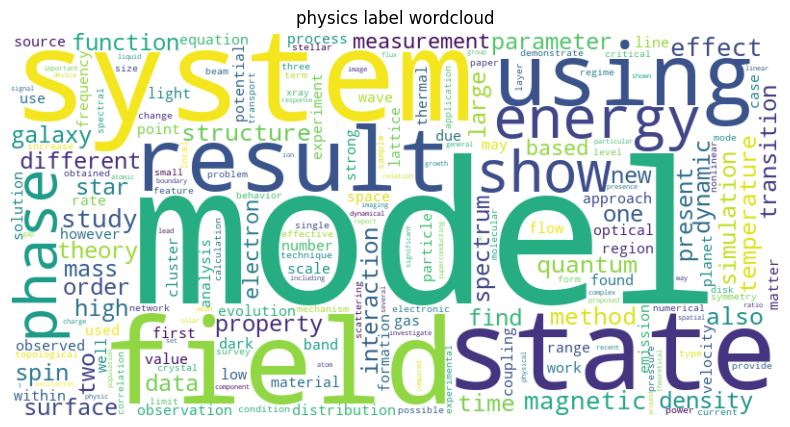

In [24]:
data=df.loc[df["label"]=="physics"]["text"]
combined_text = ' '.join(data)
words = combined_text.split()
count=Counter(words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(count)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"physics label wordcloud")
plt.show()

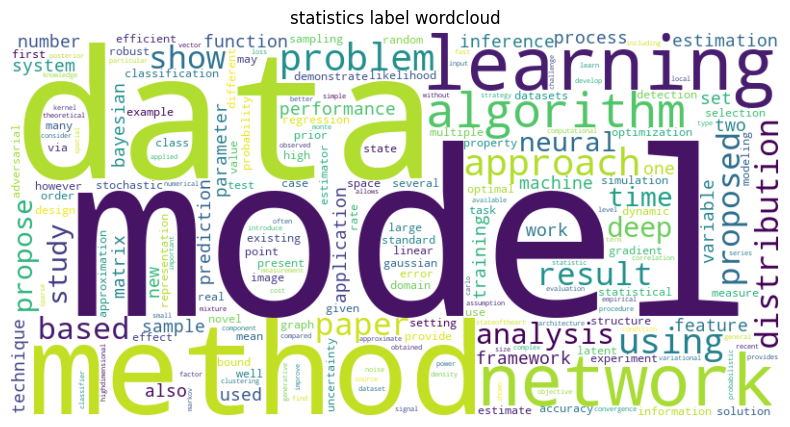

In [25]:
data=df.loc[df["label"]=="statistics"]["text"]
combined_text = ' '.join(data)
words = combined_text.split()
count=Counter(words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(count)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"statistics label wordcloud")
plt.show()

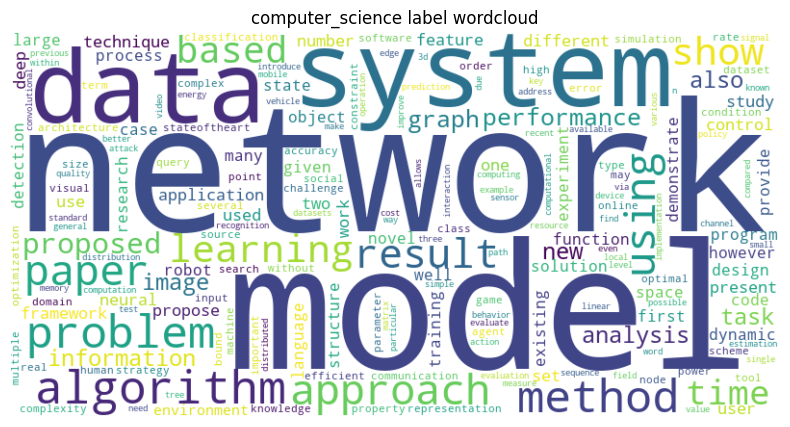

In [26]:
data=df.loc[df["label"]=="computer_science"]["text"]
combined_text = ' '.join(data)
words = combined_text.split()
count=Counter(words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(count)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"computer_science label wordcloud")
plt.show()

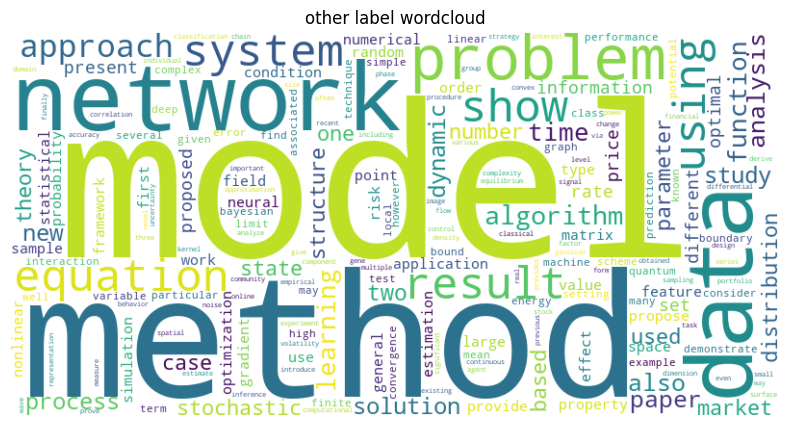

In [27]:
data=df.loc[df["label"]=="other"]["text"]
combined_text = ' '.join(data)
words = combined_text.split()
count=Counter(words)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(count)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f"other label wordcloud")
plt.show()

* we can see that some words keep repeating themselves in the wordcloud, like `data`, `model` or `network` - these words could be removed to leave out only meaningful word requency in the corpus

In [28]:
group_top_words=[val for val, _ in count.most_common(10)]
group_top_words

['model',
 'method',
 'network',
 'data',
 'problem',
 'equation',
 'system',
 'result',
 'using',
 'show']

In [29]:
def calculate_popularity(df):
    """
    NOTE: This introduces data leakage!!!
    This function should only be used on the training data
    """
    def count_top_words(text, top_10_words):
        word_counts = Counter(text.split())
        return sum(word_counts[word] for word in top_10_words)

    temp_columns = []
    for label in df["label"].unique():
        data=df.loc[df["label"]==label]["text"]
        combined_text = ' '.join(data)
        words = combined_text.split()
        count=Counter(words)
        top_10_words=[val for val, _ in count.most_common(10)]
        temp_column = f"test_{label}"
        temp_columns.append(temp_column)
        df[temp_column]=df.loc[df["label"]==label]["text"].apply(partial(count_top_words, top_10_words=top_10_words))

    df["label_popular_term_count"]=df[temp_columns].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1).astype(float)
    df=df.drop(temp_columns, axis=1)

    return df

df = calculate_popularity(df)

In [30]:
from model.utils.viz.continuous.simple import distribution

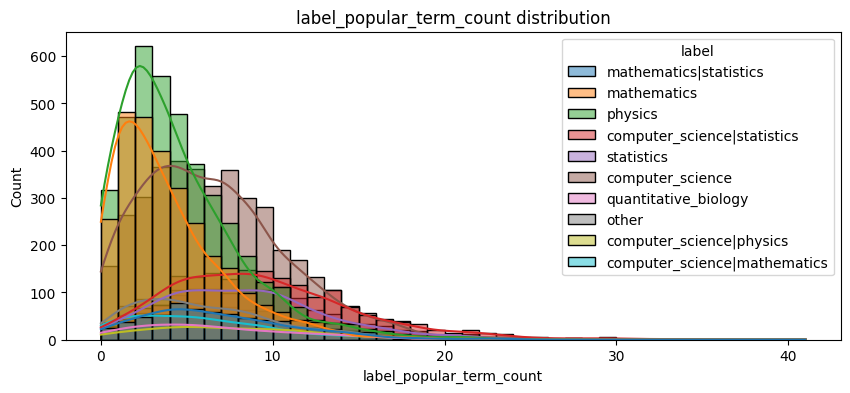

In [31]:
distribution(df=df, column="label_popular_term_count", target="label")

## 4. Modeling

In [32]:
from model.utils.models.classification import tree as mmt
from model.utils.models.classification import linear as mml
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [33]:
class ModelProject:
    def __init__(self, df:pd.DataFrame, target:str, task:Literal["regression","classification"]):
        self.y_column = target
        self.x_columns = [col for col in df.columns if col != self.y_column]
        self.task = task

        self.dtypes = self._infer_datatypes(df=df)

        if self.task == "classification":
            self.class_number = len(df[self.y_column].unique())
        else:
            self.class_number = None

    @staticmethod
    def _infer_datatypes(df) -> Dict[str,str]:
        df_types = pd.DataFrame(df.apply(pd.api.types.infer_dtype, axis=0)).reset_index().rename(columns={'index': 'column', 0: 'type'})
        dtypes = dict(df_types.values)
        return dtypes

    @property
    def numeric_colums(self) -> List[str]:
        return [ k for k,v in self.dtypes.items() if v in ["integer", "floating"]]

    @property
    def string_columns(self) -> List[str]:
        return [ k for k,v in self.dtypes.items() if v in ["string"]]

class ProcessingStep:

    def __init__(self, context:Literal["train","inference"]):
        self.context = context

    @staticmethod
    def data_cleaning(df:pd.DataFrame, context:str) -> pd.DataFrame:
        # text cleaning
        df=text_cleaning(df=df, columns=["title", "abstract"])
        df=standartize_text(df=df, columns=["title", "abstract"])

        # concatinating title and abstract. We'll treat it as one
        # as some abstracts are uninformative, however title is
        df["text"] = df["title"] + " " + df["abstract"]
        df=df.drop(["title", "abstract"], axis=1)
        if context == "inference":
            return df

        # Concatenate values into 'label' column
        label_columns = ['computer_science', 'physics', 'mathematics', 'statistics', 'quantitative_biology', 'quantitative_finance']
        df['label'] = df.apply(lambda row: '|'.join([col for col in label_columns if row[col] == 1]), axis=1)
        df=df.drop(label_columns, axis=1)
        
        return df

    @staticmethod
    def feature_engineering(df:pd.DataFrame) -> pd.DataFrame:
        df['length'] = df['text'].str.len()
        df['word_count'] = df['text'].apply(word_count)
        df['mean_word_length'] = df['text'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
        df["text_top_5"]=df["text"].apply(partial(get_top_values, n=5))
        df["text_top_10"]=df["text"].apply(partial(get_top_values, n=10))
        return df

    @staticmethod
    def deduplication(df:pd.DataFrame) -> pd.DataFrame:
        df=df.drop(df[df.duplicated("text", keep="first")].index)
        return df

    @staticmethod
    def fixing_cardinality(df:pd.DataFrame) -> pd.DataFrame:
        cardinality_treshold=len(df)*0.02
        labels_to_change=[val for val, count in Counter(df["label"]).items() if count>cardinality_treshold]
        df["label"]=df["label"].apply(lambda x:x if x in labels_to_change else "other")
        return df

    def execute(self, df:pd.DataFrame) -> pd.DataFrame:
        df = standartize_columns(df=df)
        df = self.data_cleaning(df=df, context=self.context)
        df = self.feature_engineering(df=df)
        if self.context == "inference":
            return df
        df = self.deduplication(df=df)
        df = self.fixing_cardinality(df=df)

        # fixing indexing
        df.reset_index(drop=True, inplace=True)
        return df

In [37]:
df = FeatureStore.load(stage="inputs", filename="cc_data.parquet")
df = ProcessingStep(context="train").execute(df=df)
project = ModelProject(df=df, target="label", task="classification")
df.head(5)

,text,label,length,word_count,mean_word_length,text_top_5,text_top_10
0,characterization multivariate bernoulli distri...,mathematics|statistics,620,73,7.5068,given margin fréchet class distribution,given margin fréchet class distribution densit...
1,distinction representation via bruhattits buil...,mathematics,391,49,7.0000,distinction representation article françois co...,distinction representation article françois co...
2,origin shallow replica band fese monolayer sup...,physics,1138,132,7.6288,band arpes substrate fesesto lda,band arpes substrate fesesto lda experiment co...
3,explaining recurrent neural network prediction...,computer_science|statistics,651,74,7.8108,network recurrent neural relevance lrp,network recurrent neural relevance lrp predict...
4,estimator correlation coefficient bivariate ex...,statistics,526,58,8.0862,estimator correlation coefficient exponential ...,estimator correlation coefficient exponential ...


In [38]:
X_data = df[project.x_columns]
y_data = df[project.y_column]
numeric_columns = ["length", "word_count", "mean_word_length"]

In [39]:
# we'll have a simple scaler for our linear models
numeric_pipeline = Pipeline([
    ('scale', MinMaxScaler())
])

In [40]:
# base pipeline which creates a sparse (16779, 77697) matrix
text_pipeline_1 = Pipeline([
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ('tfidf', TfidfVectorizer()),
])

# using svd to reduce dimensionality thinking it will help
text_pipeline_2 = Pipeline([
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ('tfidf', TfidfVectorizer()),
    ('truncate', TruncatedSVD(n_components=2000, random_state=42))
])

# Lastly let's try to use top 5 word group and use tfidf
# however, we additionally need to transform it to an array to make it work for such small shape:
# sparse matrix can become an empty value on specific split, however if we materialize into an array
# everything will be ok
text_pipeline_3 = Pipeline([
    ("squeez", FunctionTransformer(lambda x: x.squeeze())),
    ('tfidf', TfidfVectorizer()),
    ('truncate', TruncatedSVD(n_components=20, random_state=42)),
    ("toarray", FunctionTransformer(lambda x: x.toarray())),
])

In [41]:
# controling different column transformations
col_trans_1 = ColumnTransformer(transformers=[
    ('text', text_pipeline_1, ['text']),
    ('numeric', numeric_pipeline, numeric_columns),
], remainder='drop', n_jobs=-1)

col_trans_2 = ColumnTransformer(transformers=[
    ('text', text_pipeline_2, ['text']),
    ('numeric', numeric_pipeline, numeric_columns),
], remainder='drop', n_jobs=-1)

col_trans_3 = ColumnTransformer(transformers=[
    ('text', text_pipeline_3, ['text_top_5']),
    ('numeric', numeric_pipeline, numeric_columns),
], remainder='drop', n_jobs=-1)

In [42]:
pipeline_1 = Pipeline([
    ('preprocessing', col_trans_1)
])

pipeline_2 = Pipeline([
    ('preprocessing', col_trans_2)
])

pipeline_3 = Pipeline([
    ('preprocessing', col_trans_3)
])

* Using tfidf creates a sparse matrix of (16779, 77697) which for sure makes incorporating numeric columns useless, therefore we'll also testing dimensionality reduction to make numeric columns more available.
* Note: `TfidfVectorizer` uses `content` as an input, which assumes that it's a one object to get data from. Therefore you need `squeeze()` if you want to provide multiple columns containing data.
* Below are 3 different pipelines for testing

In [43]:
pipeline_1

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('text',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001BAE11D18A0>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer())]),
                                                  ['text']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['length', 'word_count',
                                                   'mean_word_length'])]))])

In [44]:
pipeline_2

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('text',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001BAE11D1440>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('truncate',
                                                                   TruncatedSVD(n_components=2000,
                                                                                random_state=42))]),
                                                  ['text']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['length', 'word_count',
                                                   'mean_word_length'])]))])

In [45]:
pipeline_3

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('text',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001BAE11D1760>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('truncate',
                                                                   TruncatedSVD(n_components=20,
                                                                                random_state=42)),
                                                                  ('toarray',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001BAE11D16C0>))]),
                                                  ['text_top_5']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['length', 'word_count',
                                                   'mean_word_length'])]))])

In [46]:
class evaluator():
    def __init__(self):
        self.results = pd.DataFrame()

    def score_df(self, model_name, y_pred, y_hat, execution_time, model_params, pipe_params):
        # calculate score
        acc=accuracy_score(y_true=y_hat, y_pred=y_pred)
        f1score=f1_score(y_true=y_hat, y_pred=y_pred, average="weighted")
        values = [model_name, acc, f1score, execution_time, model_params, pipe_params, datetime.datetime.now()]
        columns = ["model_name","accuracy","f1_score_weighted", "execution", "params", "pipe", "timestamp"]

        # creating dataframe
        result = pd.DataFrame([values], columns=columns)
        self.results = pd.concat([self.results, result], ignore_index=True)

class eval_cv_fold(evaluator):
    def __init__(self, n_folds:int=5, imbalanced:bool=False, target_model=None):
        self.n_folds=n_folds
        self.imbalanced = imbalanced
        self.target_model = target_model
        super().__init__()

    def eval_batch(self, X:pd.DataFrame, y:pd.Series, models=[]):
        if self.target_model:
            y=pd.Series(self.target_model.fit_transform(y))

        for model in models:
            print(f"Evaluating {model.name}")
            self.eval(X=X, y=y, model=model)

    def eval(self, X:pd.DataFrame, y:pd.Series, model) -> None:
        data_y, data_yhat = list(), list()
        start = time.time()

        if self.imbalanced:
            skf = StratifiedKFold(n_splits=self.n_folds, shuffle=True, random_state=156)
            for train_index, test_index in skf.split(X, y):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model.fit(X_train, y_train)
                pred_y = model.predict(X_test)

                # store
                data_y.extend(y_test)
                data_yhat.extend(pred_y)
        
        else:
            cv = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
            for train_index, holdout_index in cv.split(X, y):
                model.fit(X.iloc[train_index], y.iloc[train_index])
                pred_y = model.predict(X.iloc[holdout_index])

                # store
                data_y.extend(y.iloc[holdout_index])
                data_yhat.extend(pred_y)

        execution_time = time.time() - start
        try:
            pipe_steps = model.pipeline.steps
        except:
            pipe_steps = None
        
        if self.target_model:
            data_yhat=self.target_model.inverse_transform(data_yhat)
            data_y=self.target_model.inverse_transform(data_y)
        # return data_yhat
        self.score_df(model.name, data_y, data_yhat, execution_time, model.params, pipe_steps)

def combine_models_with_pipes(model_list, pipe_list, params_dict):
    output=[]
    for pipe in pipe_list:
        for model in model_list:
            params = params_dict.get(model.id, None)
            model.update_params(params=params)
            model.update_pipeline(pipeline=pipe)
            output.append(model)
    return output

In [49]:
class_pipes=[pipeline_1, pipeline_2, pipeline_3]
params_dict={
    "xgboost": {
        'objective': 'multi:softmax',
        'num_class': project.class_number,
        'eval_metric': 'mlogloss'
    }
}
class_models=[
    mml.ModelLogisticRegression(),
    mml.ModelSVC(),
    mml.ModelGaussianNB(),
    mmt.ModelDesicionTree(),
    mmt.ModelRandomForest(),
    mmt.ModelXGBoost(),
    mmt.ModelLGBM()
]
all_model_combinations=combine_models_with_pipes(model_list=class_models, pipe_list=class_pipes, params_dict=params_dict)
all_model_combinations


[ModelLogisticRegression(params={'random_state': 0},
                         pipeline=Pipeline(steps=[('preprocessing',
                                                   ColumnTransformer(n_jobs=-1,
                                                                     transformers=[('text',
                                                                                    Pipeline(steps=[('squeez',
                                                                                                     FunctionTransformer(func=<function <lambda> at 0x000001BAE11D1760>)),
                                                                                                    ('tfidf',
                                                                                                     TfidfVectorizer()),
                                                                                                    ('truncate',
                                                                                 

In [50]:
# model_results = eval_cv_fold(n_folds=2, imbalanced=True, target_model=LabelEncoder())
# model_results.eval_batch(X=X_data, y=y_data, models=all_model_combinations)
# model_results.results

* We'll be saving results of different runs into a separate file for easy access

In [ ]:
# Saving outputs for reuse:
# file_name=path.join(PROJECT_DIR, "data", "outputs", "run_3.csv")
# model_results.results.to_csv(file_name, sep='\t')

In [51]:
model_results_list=[]
files = ["run_1.csv", "run_2.csv","run_3.csv"]
file_paths = [path.join(PROJECT_DIR, "data", "outputs",file) for file in files]
for file in file_paths:
    _ = pd.read_csv(file, sep='\t').drop("Unnamed: 0", axis=1)
    model_results_list.append(_)
model_results = pd.concat(model_results_list, axis=0, ignore_index=True)
model_results.sort_values(["accuracy", "f1_score_weighted"], ascending=False)

,model_name,accuracy,f1_score_weighted,execution,params,pipe,timestamp
1,Support Vector Machine,0.6850,0.7243,820.2018,{'random_state': 0},"[('preprocessing', ColumnTransformer(n_jobs=-1...",2024-07-12 09:45:52.870538
0,Logistic Regression,0.6785,0.7216,294.4144,{'random_state': 0},"[('preprocessing', ColumnTransformer(n_jobs=-1...",2024-07-12 09:32:12.521423
5,XGBoost,0.6619,0.6994,774.4410,"{'objective': 'multi:softmax', 'num_class': 10...","[('preprocessing', ColumnTransformer(n_jobs=-1...",2024-07-12 10:15:57.450504
6,Light Gradient Boosting Machine,0.6605,0.6997,615.3760,{'random_state': 0},"[('preprocessing', ColumnTransformer(n_jobs=-1...",2024-07-12 10:26:13.006353
8,Support Vector Machine,0.6562,0.7045,20.9181,{'random_state': 0},"[('preprocessing', ColumnTransformer(n_jobs=-1...",2024-07-12 10:30:04.807029
11,Random Forest,0.6517,0.6933,15.6166,{'random_state': 0},"[('preprocessing', ColumnTransformer(n_jobs=-1...",2024-07-12 10:30:32.349703
13,Light Gradient Boosting Machine,0.6491,0.6771,10.9247,{'random_state': 0},"[('preprocessing', ColumnTransformer(n_jobs=-1...",2024-07-12 10:30:56.118199
12,XGBoost,0.6478,0.6747,12.4712,"{'objective': 'multi:softmax', 'num_class': 10...","[('preprocessing', ColumnTransformer(n_jobs=-1...",2024-07-12 10:30:45.028970
7,Logistic Regression,0.6456,0.7005,13.0573,{'random_state': 0},"[('preprocessing', ColumnTransformer(n_jobs=-1...",2024-07-12 10:29:43.749735
4,Random Forest,0.5935,0.6756,357.8870,{'random_state': 0},"[('preprocessing', ColumnTransformer(n_jobs=-1...",2024-07-12 10:03:02.833503


* Best model seems to be SVM, however, since Logistic Regression is simpler model and 3x faster - we'll leave.
* It also looks like using SVD to reduce dimensionality helped in gaining extra 3% for the Logistic regression.
* Also all of the models have been trained using their default parameters, which could be finedtuned to increase the results a little bit.

In [52]:
print(model_results.iloc[0]['pipe'])

[('preprocessing', ColumnTransformer(n_jobs=-1,
                  transformers=[('text',
                                 Pipeline(steps=[('squeez',
                                                  FunctionTransformer(func=<function <lambda> at 0x000001DC72C5CA40>)),
                                                 ('tfidf', TfidfVectorizer()),
                                                 ('truncate',
                                                  TruncatedSVD(n_components=2000,
                                                               random_state=42))]),
                                 ['text']),
                                ('numeric',
                                 Pipeline(steps=[('scale', MinMaxScaler())]),
                                 ['length', 'word_count', 'mean_word_length'])])), ('model', LogisticRegression(random_state=0))]


# Solution

* We create the final solution - Pipeline objact that reflects whole model process

In [53]:
class PipelineModel:

    def __init__(self, model, numeric_columns:List[str], text_columns:List[str]):
        self.model = model
        self.numeric_columns = numeric_columns
        self.text_columns = text_columns

    @staticmethod
    def squeeze_text(x):
        """
        lambda functions used in the FunctionTransformer is not easily serializable.
        We create function definition to be used instead.
        """
        return x.squeeze()

    @property
    def text_pipeline(self) -> Pipeline:
        return Pipeline([
            ("squeez", FunctionTransformer(func=self.squeeze_text)),
            ('tfidf', TfidfVectorizer()),
            ('truncate', TruncatedSVD(n_components=2000, random_state=42))
        ])

    @property
    def numeric_pipeline(self) -> Pipeline:
        return Pipeline([
            ('scale', MinMaxScaler())
        ])

    @property
    def preprocessing_pipeline(self) -> ColumnTransformer:
        return ColumnTransformer(transformers=[
            ('text', self.text_pipeline, self.text_columns),
            ('numeric', self.numeric_pipeline, self.numeric_columns),
        ], remainder='drop', n_jobs=-1)

    def get_pipeline(self) -> Pipeline:
        _pipeline = Pipeline([
            ('preprocessing', self.preprocessing_pipeline)
        ])
        self.model.update_pipeline(pipeline=_pipeline)
        return self.model.pipeline

* Loading the **train** and **test** data from the **feature store**

In [54]:
train_data = FeatureStore.load(stage="inputs", filename="cc_data.parquet")
train_data = ProcessingStep(context="train").execute(df=train_data)
project = ModelProject(df=train_data, target="label", task="classification")
train_data.head(4)

,text,label,length,word_count,mean_word_length,text_top_5,text_top_10
0,characterization multivariate bernoulli distri...,mathematics|statistics,620,73,7.5068,given margin fréchet class distribution,given margin fréchet class distribution densit...
1,distinction representation via bruhattits buil...,mathematics,391,49,7.0000,distinction representation article françois co...,distinction representation article françois co...
2,origin shallow replica band fese monolayer sup...,physics,1138,132,7.6288,band arpes substrate fesesto lda,band arpes substrate fesesto lda experiment co...
3,explaining recurrent neural network prediction...,computer_science|statistics,651,74,7.8108,network recurrent neural relevance lrp,network recurrent neural relevance lrp predict...


In [55]:
test_data_original = FeatureStore.load(stage="inputs", filename="cc_test.parquet")
test_data = ProcessingStep(context="inference").execute(df=test_data_original)
test_data.head(4)

,text,length,word_count,mean_word_length,text_top_5,text_top_10
0,testing sparus ii auv open platform industrial...,712,86,7.2907,application different auv platform testing,application different auv platform testing spa...
1,recent progress conditional randomness article...,259,28,8.2857,conditional recent progress randomness respect,conditional recent progress randomness respect...
2,fade fast asymptotically efficient distributed...,1343,164,7.1951,agent estimate estimator network vector,agent estimate estimator network vector parame...
3,wrong studying adversarial example impact unce...,1087,120,8.0667,adversarial example uncertainty model attack,adversarial example uncertainty model attack g...


In [56]:
pipeline = PipelineModel(model=mml.ModelLogisticRegression(), numeric_columns=project.numeric_colums, text_columns=["text"]).get_pipeline()
pipeline

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(n_jobs=-1,
                                   transformers=[('text',
                                                  Pipeline(steps=[('squeez',
                                                                   FunctionTransformer(func=<function PipelineModel.squeeze_text at 0x000001BAE11D0180>)),
                                                                  ('tfidf',
                                                                   TfidfVectorizer()),
                                                                  ('truncate',
                                                                   TruncatedSVD(n_components=2000,
                                                                                random_state=42))]),
                                                  ['text']),
                                                 ('numeric',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['length', 'word_count',
                                                   'mean_word_length'])])),
                ('model', LogisticRegression(random_state=0))])

* Training model pipeline and saving the model to the **model registry**

In [ ]:
pipeline.fit(X=train_data[project.x_columns], y=train_data[project.y_column])
ModelRegistry.save(pipeline=pipeline, name="test")

In [61]:
ModelRegistry.list_models()

* At the final steps, we'll use `ModelRegistry` to load the saved model and make predictions and concatinating them to the original testing dataset

In [58]:
y_pred = ModelRegistry.load("test_20240712.joblib").predict(test_data)
output=FeatureStore.load(stage="inputs", filename="cc_test.parquet")
output['prediction'] = y_pred

* Results doesn't look that bad

In [59]:
out={}
for i in range(5):
    out[i]=output.iloc[i].to_dict()
print(json.dumps(out, indent=4))

{
    "0": {
        "TITLE": "Testing SPARUS II AUV, an open platform for industrial, scientific and academic applications",
        "ABSTRACT": "  This paper describes the experience of preparing and testing the SPARUS II\nAUV in different applications. The AUV was designed as a lightweight vehicle\ncombining the classical torpedo-shape features with the hovering capability.\nThe robot has a payload area to allow the integration of different equipment\ndepending on the application. The software architecture is based on ROS, an\nopen framework that allows an easy integration of many devices and systems. Its\nflexibility, easy operation and openness makes the SPARUS II AUV a multipurpose\nplatform that can adapt to industrial, scientific and academic applications.\nFive units were developed in 2014, and different teams used and adapted the\nplatform for different applications. The paper describes some of the\nexperiences in preparing and testing this open platform to different\napplica

In [60]:
# Saving the output for reuse
FeatureStore.save(df=output, stage="outputs", filename="output")

---


# End

Ideas for improving:

---

* optimize for tfidf with n_gram and word frequency. This will reduce the matrix, improve speed and potentially improve the results;
* train classification model for each of the label, this way we'll be also safe when new labels appear, as we won't be needing to retrain the model with a new label;
* remove most common words from the corpus, leaving only must unique words. This way we'll reduce the tfidf sparse matrix, but should also get better results;
* try LSTM's which are also known for dealing with text data;

Other notes regarding inference:

---

* The inference is rather slow, which makes the solution unusable in production:
* We could potentially extract various elements in the pipeline and have them separately;
* For scalers, since we are using MinMax scaler - we can simply extract min and max values and to the scaling manually;
* For tfidf matrix, we could change the sparse matrix type into something more efficient such as `scipy.sparse.csr_matrix`;
* Reduce the sparse matrix, by using n_grams, max_features parameters and others;
* Use faster vectorizer, such as vectorizer from `SpaCy` or `NLTK`.
* When using simple model, like `Logistic Regression` we can reduce latency by extracting model's wheigths and doing calculations using numpy;
